# Usage and Examples
## Freely expanding 1D Gaussian wave packet
Import the pytalises package

In [1]:
import pytalises as pt
import numpy as np
import matplotlib.pyplot as plt

and instantiate a wave function constituent of 128 complex amplitudes that represent the wave function is position space.

(128,)


Text(0.5, 1.0, 'Prob. amplitude of wave function')

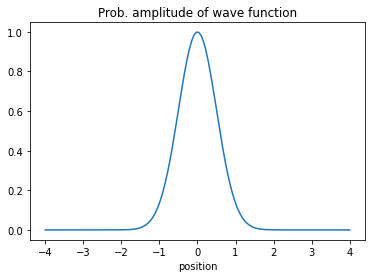

In [2]:
psi = pt.Wavefunction("exp(-x**2)",
    number_of_grid_points=(128,), spatial_ext=(-4,4))
print(psi.amp.shape)
plt.plot(psi.r, np.abs(psi.amp)**2)
plt.xlabel("position")
plt.title("Prob. amplitude of wave function")

The wave packet can be freely propagated (meaning that $V=0$, or $i\partial_t \psi (r,t)=\frac{\hbar}{2m}\nabla^2 \psi(r,t)$) using the `freely_propagate` method.

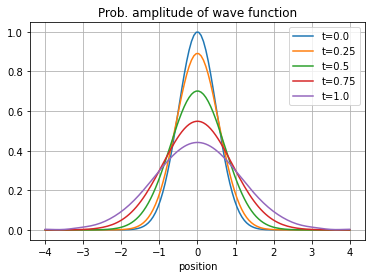

In [3]:
for i in range(5):
    plt.plot(psi.r, np.abs(psi.amp)**2, label="t="+str(psi.t))
    psi.freely_propagate(num_time_steps=1, delta_t=0.25)
plt.xlabel("position")
plt.title("Prob. amplitude of wave function")
plt.legend()
plt.grid()

## Free expansion with initial momentum
The wave funciton can be given an initial momentum of $k$ by multiplying it with $\exp (ikx)$.

In [4]:
psi = pt.Wavefunction('exp(-(x-x0)**2)*exp(1j*k*x)',
    variables={'x0': -5.0, 'k': 10.0}, number_of_grid_points=(128,),
    spatial_ext=(-10,10))

The variables that we use in the string to generate the wave function can also be provided by a dictionary as done here. The wave function is offset by $x_0 = -5$.

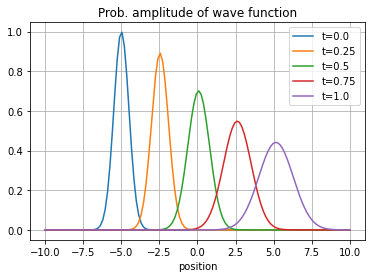

In [5]:
for i in range(5):
    plt.plot(psi.r, np.abs(psi.amp)**2, label="t="+str(psi.t))
    psi.freely_propagate(num_time_steps=1, delta_t=0.25)
plt.xlabel("position")
plt.title("Prob. amplitude of wave function")
plt.legend()
plt.grid()

After one time unit, the wave packet traveled 10 position units from $-5$ to $5$, as expected with momentum $k=10$.  


**Attention**: This unitless representation is due to the fact that we did not define a mass (optional keyword argument `m`) for the `pytalises.Wavefunction` class. In that case the Schrödinger equation simply became

$$
i\partial\psi(r,t) = \frac{1}{2}\nabla^2 \psi(r,t).
$$

The default value for the `m` keyword argument of the `pytalises.Wavefunction` class is numerically identical to $\hbar$.
The Schrödinger equation that is solved in pytalises is actually

$$
i\partial\psi(r,t) = \bigg( \frac{\hbar}{2m}\nabla^2 + \frac{1}{\hbar}V(r,\psi(r,t),t)\bigg) \psi(r,t).
$$

Therefore, always keep in mind that the potential you define $V(r,\psi(r,t),t)$ has to be divided by $\hbar$.

## 2D harmonic potential
Now we propagate a wavefunction in a potential $V/\hbar = \frac{1}{2}\omega_x^2 x^2 + \frac{1}{2}\omega_y^2 y^2$ (if not otherwise specified, the mass always equals $\hbar$). Furthermore, we chose $\omega_y = \omega_x = 2\pi 1 \text{s}^{-1}$. One period in the harmonic trap takes one second.
The Schrödinger equation is then
$$
i\partial_t \psi (x,y,t) = \bigg(\frac{1}{2}\omega^2 (x^2 +  y^2) + \frac{1}{2}\nabla^2\bigg) \psi (x,y,t).
$$

Now we can use the `propagate` method of the `pytalises.Wavefunction` class to do so.

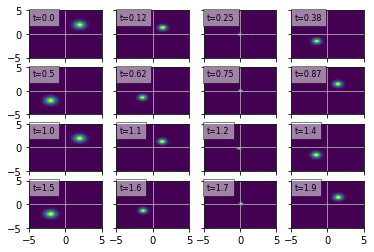

In [6]:
psi = pt.Wavefunction("exp(-(x-2)**2-(y-2)**2)",
    number_of_grid_points= (128,128), spatial_ext=[(-5,5),(-5,5)])

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        axs[i,j].pcolormesh(psi.r[0], psi.r[1], np.abs(psi.amp**2).T,
            rasterized=True)
        axs[i,j].annotate("t={:.2}".format(psi.t), (-4.5,3), fontsize=8)\
            .set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='black'))
        axs[i,j].grid()
        psi.propagate("1/2*omega_x**2*x**2 + 1/2*omega_y**2*y**2",
            variables={'omega_x': 2*np.pi*1, 'omega_y': 2*np.pi*1},
            diag=True, num_time_steps=10, delta_t=0.0125)

For better demonstration we also animate the time evolution

In [7]:
from matplotlib import animation, rc
from IPython.display import HTML
def init():
    im.set_data(np.abs(psi.amp)**2) 
    return (im,)

def animate(i):
    psi.propagate("1/2*omega_x**2*x**2 + 1/2*omega_y**2*y**2",
        variables={'omega_x': 2*np.pi*1, 'omega_y': 2*np.pi*1},
        diag=True, num_time_steps=1, delta_t=0.005)
    im.set_data(np.abs(psi.amp)**2)
    return (im,)

psi = pt.Wavefunction("exp(-(x-2)**2-(y-2)**2)",
    number_of_grid_points= (128,128), spatial_ext=[(-5,5),(-5,5)])

fig, ax = plt.subplots()
im = ax.imshow(np.abs(psi.amp)**2,
    vmin=0,
    vmax=10*np.max(np.abs(psi.amp)**2),
    origin='lower')
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

One can see that the wave packet moves periodically with a frequency of one period per time unit in a diagonal line of the 2D harmonic trap. One could also use the `exp_pos` method of the `Wavefunction` class that returns the mean position of a wave function when called, in order to show the harmonic oscillation.

Note that we called the `propagate` method with the keyword argument `diag=True`. This makes the calculation for the time propagation faster as no numerically diagonalization of the potential energy term is invoked (even though with only one internal state, the potential $V$ can not have any nondiagonal terms).

In [8]:
def time_propagate(diag):
    psi = pt.Wavefunction("exp(-(x-2)**2-(y-2)**2)",
        number_of_grid_points= (128,128), spatial_ext=[(-5,5),(-5,5)])
    psi.propagate("1/2*omega_x**2*x**2 + 1/2*omega_y**2*y**2",
        variables={'omega_x': 2*np.pi*1, 'omega_y': 2*np.pi*1},
        diag=diag, num_time_steps=10, delta_t=0.0125)
%timeit time_propagate(diag=True)
%timeit time_propagate(diag=False)

19.1 ms ± 550 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.7 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Rabi cycles in two level system
In this example a Gaussian wave packet in a ground state is coherently transferred to an excited state. During this the wave packet will further disperse. The time evolution is described by

$$
i \partial_t \psi (x,t) = 
\Bigg(
\frac{1}{2}
\begin{pmatrix}
0 & \Omega_R\\
\Omega_R & 0
\end{pmatrix}
+
\frac{1}{2}\nabla^2
\Bigg)
\psi (x,t).
$$

The well known Rabi model in addition of the kinetic term.  


> **Attention**: When defining the list of strings that describe the potential term $V$, be aware that for the general case you must provide the lower triangular part of $V$.  


For example if

$$
V = 
\begin{pmatrix}
V_{11} & V_{12}\\
V_{21} & V_{22}
\end{pmatrix}
$$

you must pass the `propagate` method a list `[V11, V21, V22]`. We can omit the other element because $V_{21}=V_{12}^*$ for hermitian matrices. That means if you have a nondiagonal potential $V$ describing the time evolution of a wave function with $N_\text{int}$ number of internal degrees of freedom, the $N_\text{int}\times N_\text{int}$ matrix $V$ is described by a list of matrix elements of length $\frac{1}{2}N_\text{int}(N_\text{int}+1)$.

> **Note**: If you are using `diag=True` in the `propagate` method you only have to provide the diagonal matrix elements $V_{ii}$ of $V$. Thus, the list is of length $N_\text{int}$.  


The Rabi frequency will be $\Omega_R=2\pi f_R = 2\pi 1\text{s}^{-1}$, such that after one time unit a complete population inversion is achieved.
We also keep track of the state occupation number of each internal state by calling the `state_occupation` method each timestep.

In [9]:
def init():
    return (line1,line2,line3,line4,)

def animate(i):
    pop0[i] = psi.state_occupation(0)
    pop1[i] = psi.state_occupation(1)
    psi.propagate(["0", "2*pi*f_R/2", "0"], variables={'f_R': 1, 'pi': np.pi},
        num_time_steps=1, delta_t=delta_t)
    line1.set_ydata(np.abs(psi.amp[:,0])**2)
    line2.set_ydata(np.abs(psi.amp[:,1])**2)
    line3.set_ydata(pop0)
    line4.set_ydata(pop1)
    return (line1,line2,line3,line4,)

psi = pt.Wavefunction(["exp(-x**2)", "0"], number_of_grid_points=(64,),
    spatial_ext=[(-5,5)], normalize_const=1.0 )

fig, axs = plt.subplots(2,1)
line1,line2, = axs[0].plot(psi.r, np.abs(psi.amp[:,0])**2, psi.r, np.abs(psi.amp[:,1])**2)
axs[0].set_xlabel("position")
axs[0].set_ylabel("population density")
axs[0].set_xlim(-5,5)
n_timesteps = 300
delta_t = 0.005
t = np.linspace(0, delta_t*n_timesteps, num=n_timesteps)
pop0 = -np.ones(n_timesteps)
pop1 = -np.ones(n_timesteps)
line3,line4, = axs[1].plot(t, pop0, t, pop1, marker=".", linestyle="", markersize=1)
axs[1].set_xlabel("time")
axs[1].set_ylabel("population")
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,delta_t*n_timesteps)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_timesteps, interval=10, blit=True)
plt.close()
HTML(anim.to_html5_video())

Note that in this example we have a nondiagonal potential as the eigenstates interact. Thus we can not use the `diag=True` option that was used in the previous example in order to speed up the calculations.

## Diffraction on grating
In this example a 2d Gaussian wave packet is diffracted on a periodic potential.
The library that is uses by pytalises to evaluate mathematical expressions that describe wave functions or potentials is [numexpr](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/index.html). A list of supported operators and functions that you can use to construct your wave function or potential can be found [here](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/user_guide.html#supported-operators). In this specific example we use the `where(cond, a, b)` function for realizing the potential. It either outputs `a` or `b` depending on whether the condition `cond` is fulfilled or not.  

Let's plot the wave function and potential

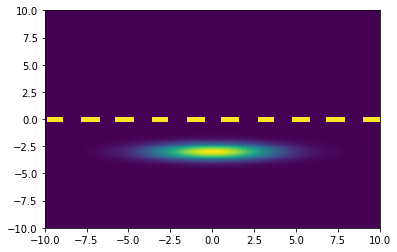

In [10]:
import numexpr as ne

psi = pt.Wavefunction(
    "exp(-((x-x0)/sigmax)**2)*exp(-((y-y0)/sigmay)**2)*exp(1j*ky*y)", 
    variables={'x0': 0, 'y0': -3, 'sigmax':5, 'sigmay': 1, 'ky': 3 },
    number_of_grid_points=(128,256),
    spatial_ext=[(-10,10),(-10,10)],
    )
# String that describes the potential (see numexpr documentaiton for allowed functions)
v = "where(y<.2, 1, 0)*where(y>-.2, 1, 0)*where(cos(3*x)<0, 1, 0)*1000"
potential = ne.evaluate(v, local_dict=psi.default_var_dict)[:,:,0]
plt.pcolormesh(psi.r[0], psi.r[1],
    (np.abs(psi.amp**2)+potential).T,
    rasterized=True, vmax=np.max(np.abs(psi.amp**2)))

We have given the wave function an initial momentum of $k_y=3$ and offset it by $y_0=-3$.
After one time unit the center of mass will have collided with the periodic grating.

In [11]:
def init():
    im.set_data(np.abs(psi.amp.T)**2) 
    return (im,)

def animate(i):
    psi.propagate(v, num_time_steps=5, delta_t=0.002, diag=True)
    im.set_data((np.abs(psi.amp**2)+potential).T)
    return (im,)

fig, ax = plt.subplots()
im = ax.imshow((np.abs(psi.amp**2)+potential).T,
    origin='lower', vmax=np.max(np.abs(psi.amp**2)),
    aspect='auto')
anim = animation.FuncAnimation(fig, animate, init_func=init,
    frames=300, interval=10, blit=True)
plt.close()
HTML(anim.to_html5_video())

## Nonlinear interactions between internal states
In addition to the variables `x`,`y`,`z` and `t` you can use wave function amplitudes in your defined potentials to solve a nonlinear Schrödinger equation

$$
i\partial_t \psi (r,t) = 
\bigg(
    \frac{\hbar}{2m}\nabla^2+\frac{1}{\hbar}V(r,t,\psi (r,t))
\bigg)
\psi (r,t)
$$

Depending on the number of internal states `N` your wave function has, the wave function amplitudes can be used in the potential by calling `psi0`, `psi1` ... `psiN`.

In this example we create a wave function with two internal states. The first one is going to be stationary in position space whilst the other approaches it and scatters.

The equation that we solve is

$$
i \partial_t 
\begin{bmatrix}
\psi_0 (x,t) \\
\psi_1 (x,t)
\end{bmatrix}
= 
\Bigg(
\frac{1}{2}
\begin{bmatrix}
0 & 0\\
0 & g\cdot |\psi_0(x,t)|^2
\end{bmatrix}
+
\frac{1}{2}\nabla^2
\Bigg)
\begin{bmatrix}
\psi_0 (x,t) \\
\psi_1 (x,t)
\end{bmatrix}.
$$

In [12]:
def init():
    return (line1,line2,)

def animate(i):
    psi.propagate(["0","g/2*abs(psi0)**2"],
        variables={'g': 400},
        num_time_steps=1, delta_t=0.01, diag=True)
    line1.set_ydata(np.abs(psi.amp[:,0])**2)
    line2.set_ydata(np.abs(psi.amp[:,1])**2)
    return (line1,line2,)

psi = pt.Wavefunction(
    ["exp(-(x/2/sigmax)**2)","exp(-((x+x0)/2/sigmax)**2)*exp(1j*k*x)"], 
    variables={'x0': 20, 'sigmax':2, 'k': 20 },
    number_of_grid_points=(512,),
    spatial_ext=(-30,30),
    )

fig, ax = plt.subplots()
line1,line2, = ax.plot(psi.r, np.abs(psi.amp[:,0])**2, psi.r, np.abs(psi.amp[:,1])**2)
ax.set_xlabel("position")
ax.set_ylabel("population density")

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=250, interval=10, blit=True)
plt.close()
HTML(anim.to_html5_video())

Now you should have a good overview of pytalises' capabilities.
For more interesting applications we recoomend reading [the additional examples page.](additional_examples.ipynb)